<a href="https://colab.research.google.com/github/Dev2104/data-science/blob/main/AI_%26_ML_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing neccessary libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report



SEED = 42
EPOCHS = 12
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

#  6 hidden layers:
HIDDEN_UNITS = (256, 256, 128, 128, 64, 64)

np.random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("MNIST Loaded")
print("Train images:", x_train.shape, "Train labels:", y_train.shape)
print("Test  images:", x_test.shape, "Test  labels:", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MNIST Loaded
Train images: (60000, 28, 28) Train labels: (60000,)
Test  images: (10000, 28, 28) Test  labels: (10000,)


In [3]:
# Preprocessing data

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [4]:
#Ploting utilities

def show_plot():

    plt.show(block=True)
    plt.pause(0.1)
    plt.close()


def plot_history(history, title_prefix: str):
    hist = history.history

    # Accuracy
    plt.figure()
    plt.plot(hist["accuracy"], label="Train Accuracy")
    plt.plot(hist["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.legend()
    show_plot()

    # Loss
    plt.figure()
    plt.plot(hist["loss"], label="Train Loss")
    plt.plot(hist["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()
    show_plot()


def plot_confusion_matrix(cm: np.ndarray, title: str):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    show_plot()


def show_sample_predictions(x_flat, y_true, y_pred, title: str, n: int = 16):

    n = int(n)
    n = max(1, min(n, len(x_flat)))

    idx = np.random.choice(len(x_flat), size=n, replace=False)

    cols = 4
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(10, 8))
    for i, j in enumerate(idx, start=1):
        img = x_flat[j].reshape(28, 28)
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{y_true[j]}  P:{y_pred[j]}")
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    show_plot()

In [5]:
#  Model builder: Input + 6 Hidden + Output(10 Softmax)

def build_model(hidden_activation: str) -> tf.keras.Model:
    if len(HIDDEN_UNITS) != 6:
        raise ValueError("Requirement violation: you must have exactly 6 hidden layers.")

    model = models.Sequential(name=f"MNIST_{hidden_activation.upper()}_6HL")
    model.add(layers.Input(shape=(784,), name="input_layer"))

    for i, units in enumerate(HIDDEN_UNITS, start=1):
        model.add(layers.Dense(units, activation=hidden_activation, name=f"hidden_{i}_{units}"))

    # Output layer: 10 classes (0-9) with Softmax probability distribution
    model.add(layers.Dense(10, activation="softmax", name="output_softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [6]:
# Training & Evaluating function

def train_and_evaluate(hidden_activation: str, show_wrong_only: bool = False):
    model = build_model(hidden_activation)

    print("\n" + "=" * 80)
    print(f"Training model: {model.name}")
    model.summary()


    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
    ]

    history = model.fit(
        x_train_flat, y_train_cat,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=callbacks
    )

    test_loss, test_acc = model.evaluate(x_test_flat, y_test_cat, verbose=0)

    probs = model.predict(x_test_flat, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    # Printing results
    print("\n" + "-" * 80)
    print(f"{hidden_activation.upper()} RESULTS")
    print(f"Test Loss:     {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Showing training curves
    plot_history(history, title_prefix=f"{hidden_activation.upper()} Hidden Layers")

    # Showing confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, title=f"Confusion Matrix - {hidden_activation.upper()} Hidden Layers")

    # Showing sample images (either random samples or wrong predictions)
    if show_wrong_only:
        wrong_idx = np.where(y_pred != y_test)[0]
        print(f"\nWrong predictions: {len(wrong_idx)} / {len(y_test)}")
        if len(wrong_idx) > 0:
            show_sample_predictions(
                x_flat=x_test_flat[wrong_idx],
                y_true=y_test[wrong_idx],
                y_pred=y_pred[wrong_idx],
                title=f"Wrong Predictions - {hidden_activation.upper()}",
                n=16
            )
        else:
            print("No wrong predictions found in the selected set (rare).")
    else:
        show_sample_predictions(
            x_flat=x_test_flat,
            y_true=y_test,
            y_pred=y_pred,
            title=f"Sample Predictions - {hidden_activation.upper()}",
            n=16
        )

    return test_loss, test_acc



Training model: MNIST_SIGMOID_6HL


Model: "MNIST_SIGMOID_6HL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1_256 (Dense)            │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2_256 (Dense)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3_128 (Dense)            │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4_128 (Dense)            │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_5_64 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_6_64 (Dense)             │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,226 (1.26 MB)

 Trainable params: 329,226 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1881 - loss: 2.0698 - val_accuracy: 0.5240 - val_loss: 1.1754
Epoch 2/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6464 - loss: 1.0063 - val_accuracy: 0.9103 - val_loss: 0.4279
Epoch 3/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9002 - loss: 0.4163 - val_accuracy: 0.9363 - val_loss: 0.2577
Epoch 4/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9358 - loss: 0.2575 - val_accuracy: 0.9502 - val_loss: 0.1983
Epoch 5/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9492 - loss: 0.1964 - val_accuracy: 0.9617 - val_loss: 0.1499
Epoch 6/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9607 - loss: 0.1554 - val_accuracy: 0.9670 - val_loss: 0.1316
Epoch 7/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9683 - loss: 0.1254 - val_accuracy: 0.9682 - val_loss: 0.1186
Epoch 8/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9722 - loss: 0.1068 - val_ac

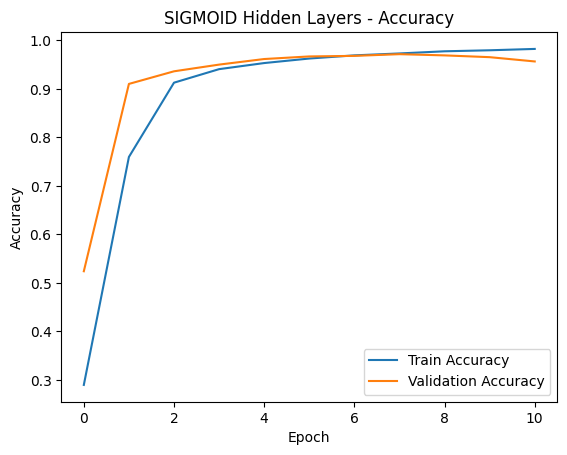

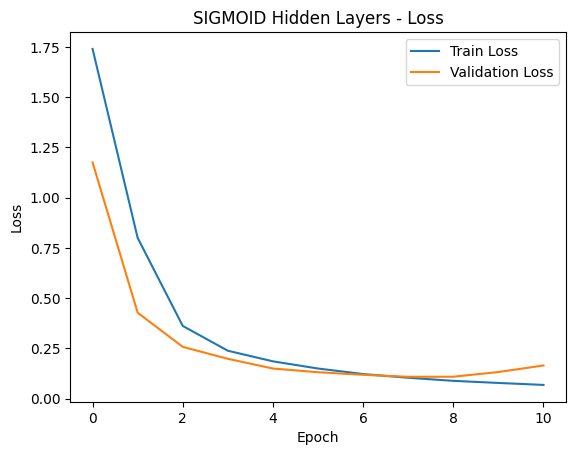

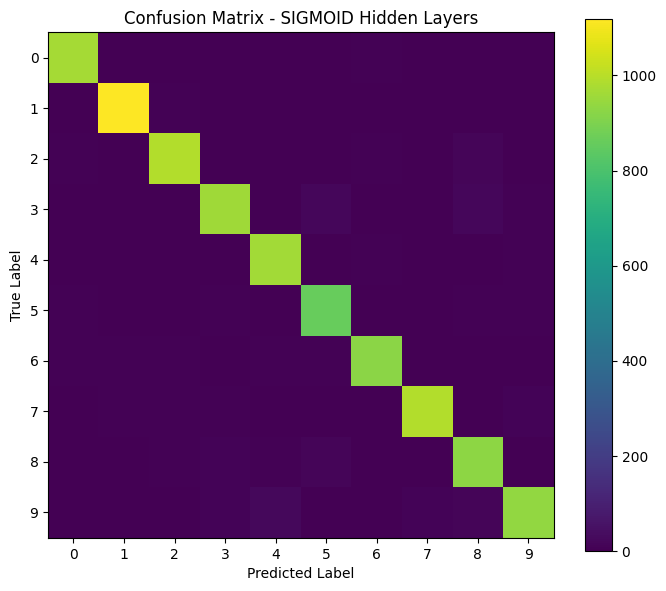

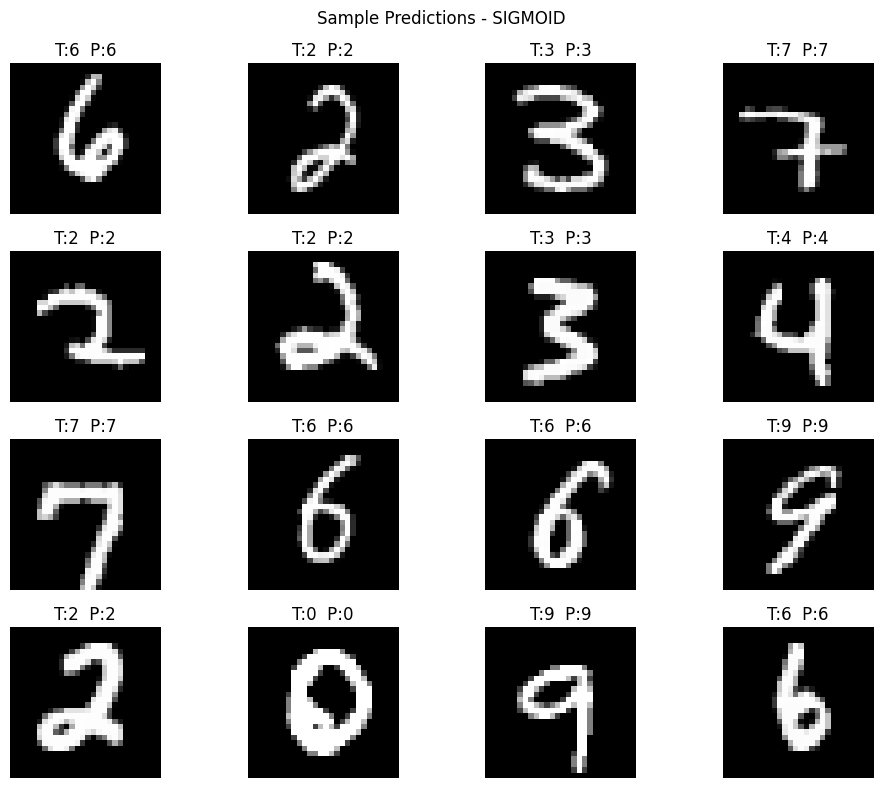


Training model: MNIST_TANH_6HL


Model: "MNIST_TANH_6HL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1_256 (Dense)            │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2_256 (Dense)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3_128 (Dense)            │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4_128 (Dense)            │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_5_64 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_6_64 (Dense)             │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,226 (1.26 MB)

 Trainable params: 329,226 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8621 - loss: 0.4882 - val_accuracy: 0.9597 - val_loss: 0.1370
Epoch 2/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9562 - loss: 0.1480 - val_accuracy: 0.9700 - val_loss: 0.1008
Epoch 3/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9704 - loss: 0.0992 - val_accuracy: 0.9685 - val_loss: 0.1025
Epoch 4/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9781 - loss: 0.0722 - val_accuracy: 0.9708 - val_loss: 0.0889
Epoch 5/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9811 - loss: 0.0600 - val_accuracy: 0.9715 - val_loss: 0.0969
Epoch 6/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9864 - loss: 0.0451 - val_accuracy: 0.9692 - val_loss: 0.1146
Epoch 7/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9875 - loss: 0.0394 - val_accuracy: 0.9693 - val_loss: 0.1117

--------------------------------------------------------------------------------
TANH RESULTS
T

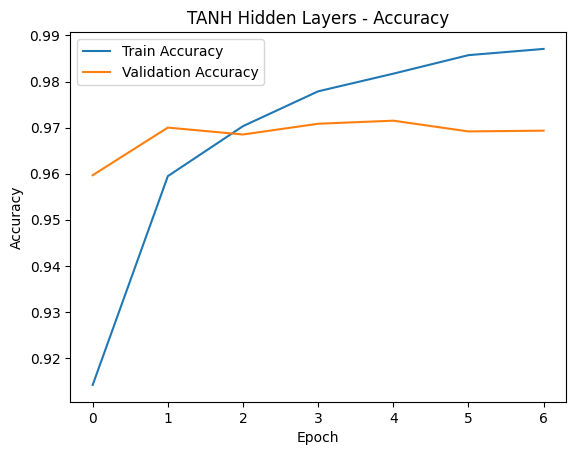

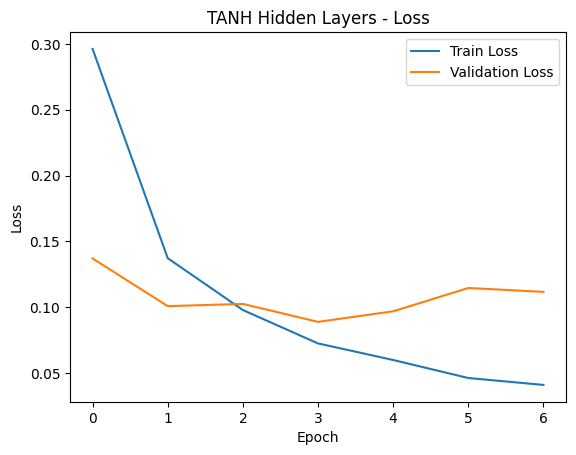

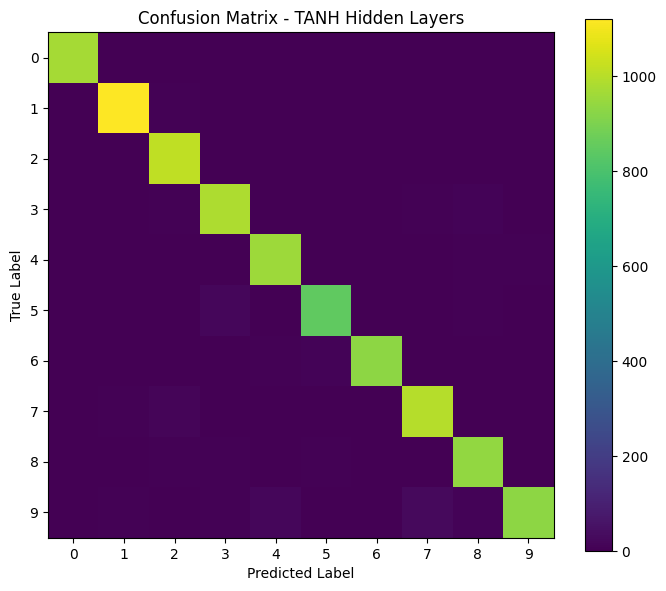

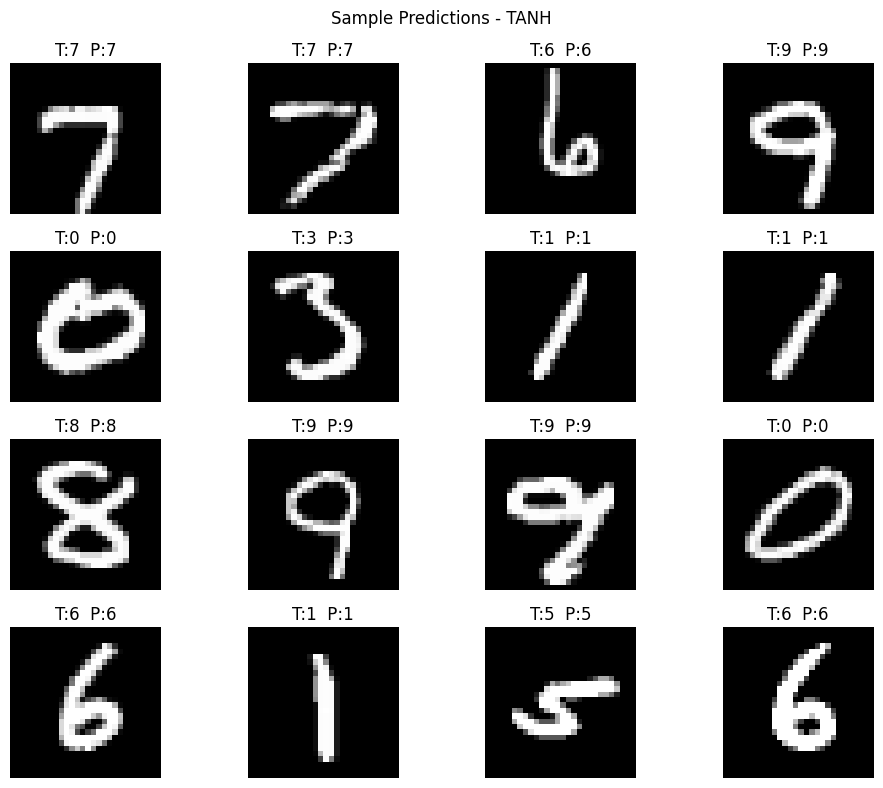


FINAL COMPARISON (Test Set)
Sigmoid -> Loss: 0.1365, Accuracy: 0.9644
Tanh    -> Loss: 0.0990, Accuracy: 0.9691


In [7]:
# Runing both experiments: Sigmoid vs Tanh

sig_loss, sig_acc = train_and_evaluate("sigmoid", show_wrong_only=False)
tanh_loss, tanh_acc = train_and_evaluate("tanh", show_wrong_only=False)

print("\n" + "=" * 80)
print("FINAL COMPARISON (Test Set)")
print(f"Sigmoid -> Loss: {sig_loss:.4f}, Accuracy: {sig_acc:.4f}")
print(f"Tanh    -> Loss: {tanh_loss:.4f}, Accuracy: {tanh_acc:.4f}")